In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import scipy.signal

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc("font",size=LARGE_SIZE)
plt.rc("axes",titlesize=LARGE_SIZE)
plt.rc("axes",labelsize=LARGE_SIZE)
plt.rc("xtick",labelsize=LARGE_SIZE)
plt.rc("ytick",labelsize=LARGE_SIZE)
plt.rc("legend",fontsize=LARGE_SIZE)
plt.rc("figure",titlesize=LARGE_SIZE)

In [9]:
### Physical Constant ###
### DO NOT EDIT ###

# Specific Ionic constants     (l/g_ion)

HNa  = -0.550
HCa  = -0.303
HMg  = -0.314
HH   = -0.774
HCl  =  0.844
HCO3 =  0.485
HHO  =  0.941


# Molecular masses     (g/mol)

MNaCl  = 58.5
MCaCO3 = 90
MMgCl2 = 95
MNa    = 23
MCa    = 40
MMg    = 24
MCl    = 35.5
MCO3   = 60 


# Kinetic constants
   
miu_P  = 1.790      # [1/h]
Ks     = 1.030      # [g/l]
Ks1    = 1.680      # [g/l]      
Kp     = 0.139      # [g/l]
Kp1    = 0.070      # [g/l]
Rsx    = 0.607
Rsp    = 0.435
YO2    = 0.970      # [mg/mg]
KO2    = 8.86       # [mg/l]
miu_O2 = 0.5        # [1/h]
A1     = 9.5e8
A2     = 2.55e33
Ea1    = 55000      # J/mol
Ea2    = 220000     # J/mol
R      = 8.31       # J/(mol.K)


# thermodynamic constants

Kla0   = 38        # [1/h]
KT     = 100*3600  # [J/hm2K]
Vm     = 50        # [l]
AT     = 1         # [m2]
ro     = 1080      # [g/l]
ccal   = 4.18      # [J/gK]         
roag   = 1000      # [g/l]
ccalag = 4.18      # [J/gK]
deltaH = 518       # [kJ/mol O2 consumat]

 
# Initial data

mNaCl  = 500        # [g]
mCaCO3 = 100        # [g]
mMgCl2 = 100        # [g]
pH     = 6
Tiag   = 15         # [癈]


# Initial Conditions

x0 = [1000, 0.90467678228155, 12.51524128083789, 29.73892382828279, 3.10695341758232, 29.57321214183856, 27.05393890970931]


In [11]:
### If you are interested, the simulation is achieved by runing the model without the time delay and mannully shift the time for the model.
### The feedback is achieved by accessing the process output on previous time (time delay enables this).

## solve one step of the model, time is an array [t_initial, t_end]
def solve_step(time, x0, Fi, Fe, T_in, cS_in, Fag, result):
    t_eval = np.linspace(time[0],time[1],T_POINT)
    ### changed to BDF method stablized the oxygen concentration
    sol = scipy.integrate.solve_ivp(model, time, x0,args=(Fi,Fe,T_in,cS_in,Fag), t_eval=t_eval, method='BDF')
    if time[0] == 0:
        result = np.concatenate((result, sol.y), axis=1)
    else:
        result = np.concatenate((result, sol.y[:,1:]), axis=1)
    return result

## Find the current output of your system time is integer and returns the process data for 1 step with number of point equal to T_POINT
def current_output(time, result):
    process_time = int(time*(T_POINT-1))
    return result[:,process_time:int((time+1)*(T_POINT-1)+1)]

## Find the setpoint of your process.
def set_point(time, x0):
    result = np.zeros([7,T_DELAY*(T_POINT-1)])
    for i in range(time[1]-T_DELAY):
        if i == 0:
            x0=x0
        Fi = lambda t: 51
        Fe = lambda t: 51
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18
        result = solve_step([i, i+1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:,-1]
    return result

Ideally everything above shoule not be edited and should be used as black box

In [12]:
## Function that runs the entie feedback loop. time is an array with [t_inital, t_end], x0 is the initial condition
def dynamic_model(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros([7,T_DELAY*(T_POINT-1)])
    for i in range(time[1]-T_DELAY):
        ##Cover the edge case
        if i == 0:
            x0=x0

        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i,result) # find the current output of the process
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i,result_sp) # Find the current setpoint of the process
        ## process input, you may need to specify as disturbance in the problem statement or you need to use controller to adjust the input
        Fi = lambda t: 51
        Fe = lambda t: 51
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18

        ## Find your error

        ## Construct your transfer function


        t_eval = np.linspace(i,i+1,T_POINT) ## your transfer function should evaluate on the same time point as the model (this is your sampling point)
        
        ## Simulate your input to the model
       
        ## Your solve_step can take both a callable function for Fi, Fe, T_in, cS_in, Fag or an array of data at the given [i, i+1] time window.
        ## ie your simulated input to process can be directly feed into the solve_step, and you can also define disturbance as function and pass into the solve_step
        result = solve_step([i, i+1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:,-1]
    t = np.linspace(time[0],time[1],(time[1] - time[0])*(T_POINT-1)+1) ## entire sampling time for the process 
    return t, result, result_sp


In [13]:
t_final = 100 ### final time for you model
t, result, result_sp = dynamic_model([0,t_final], x0) ### run the model

### Notice, you may find offest when you do you controller, and we are trying to identiy if that's
### what pthon do or there is a small bug on the code, but it shouldn't affect your design.

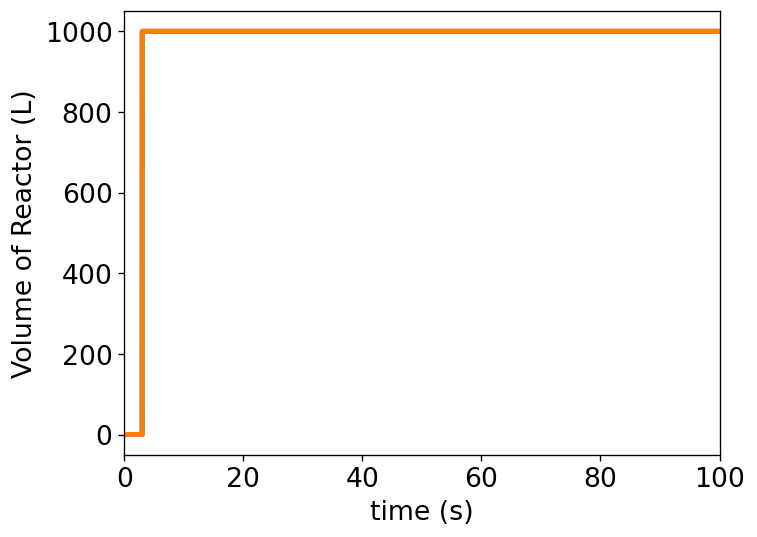

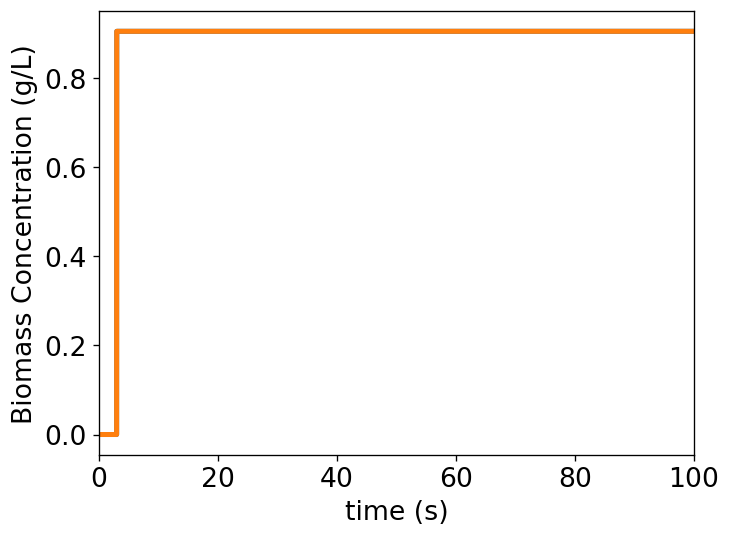

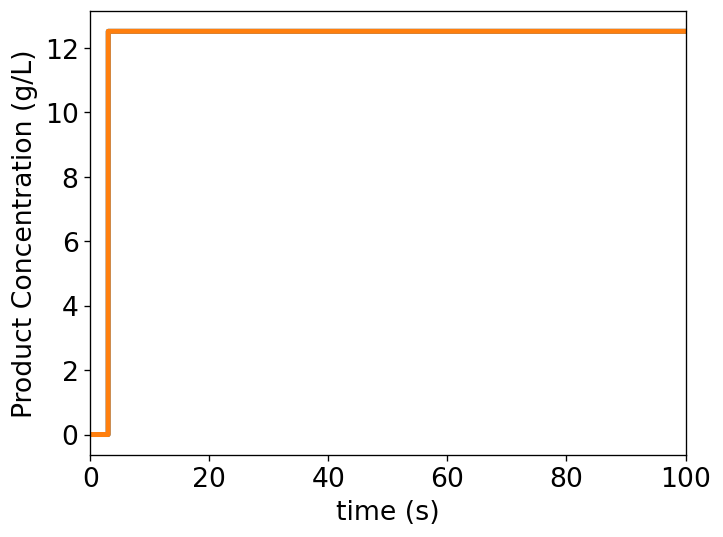

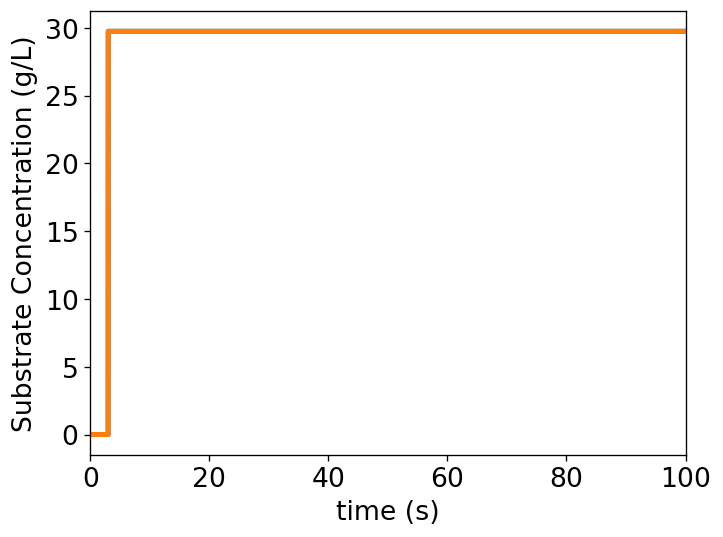

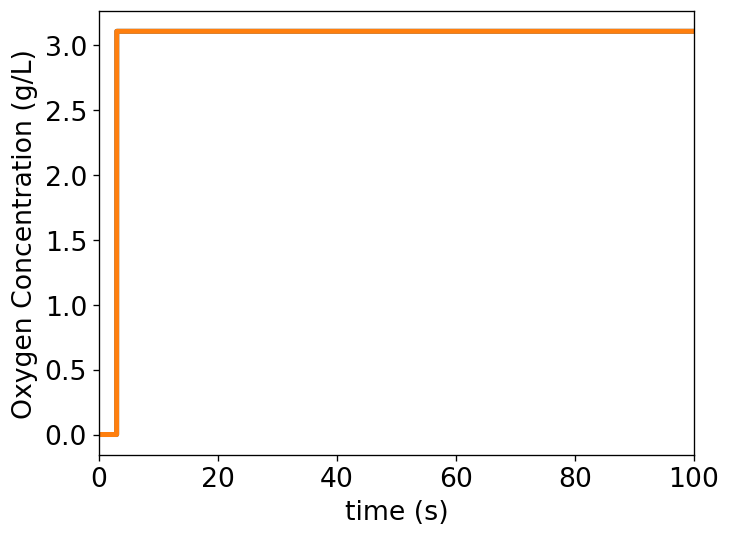

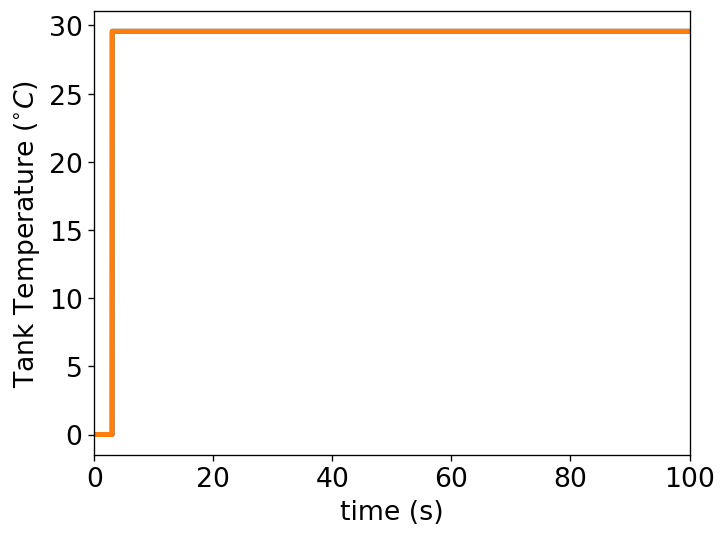

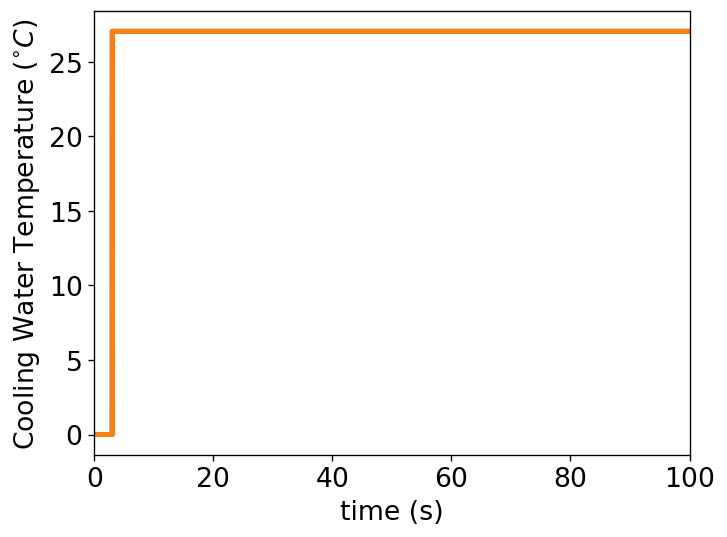

In [14]:
### Ploting ###

plt.figure(dpi=120)
plt.plot(t,result[0],lw=3)
plt.plot(t,result_sp[0],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Volume of Reactor (L)")


plt.figure(dpi=120)
plt.plot(t,result[1],lw=3)
plt.plot(t,result_sp[1],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Biomass Concentration (g/L)")

plt.figure(dpi=120)
plt.plot(t,result[2],lw=3)
plt.plot(t,result_sp[2],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Product Concentration (g/L)")

plt.figure(dpi=120)
plt.plot(t,result[3],lw=3)
plt.plot(t,result_sp[3],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Substrate Concentration (g/L)")

plt.figure(dpi=120)
plt.plot(t,result[4],lw=3)
plt.plot(t,result_sp[4],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Oxygen Concentration (g/L)")

plt.figure(dpi=120)
plt.plot(t,result[5],lw=3)
plt.plot(t,result_sp[5],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Tank Temperature ($^{\circ} C$)")

plt.figure(dpi=120)
plt.plot(t,result[6],lw=3)
plt.plot(t,result_sp[6],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Cooling Water Temperature ($^{\circ} C$)")
plt.show()